# ResNet-15 for Electron-Photon Classification

We are given that the datasets has two channels, instead of the standard 3 (RGB) channels.

In [1]:
import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.notebook import tqdm

Let's load the datasets and have a look at the structure

In [ ]:
# Used in Kaggle 
# ELECTRON = "/kaggle/input/electron-photon-classification-dataset/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"
# PHOTON = "/kaggle/input/electron-photon-classification-dataset/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5"

In [ ]:
ELECTRON = "/home/yukinatsu/gsoc/vision/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"
PHOTON = "/home/yukinatsu/gsoc/vision/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5"

In [3]:
elec_data = h5py.File(ELECTRON, "r")
list(elec_data.keys())

['X', 'y']

In [4]:
x_elec = elec_data["X"][:]
x_elec.shape


(249000, 32, 32, 2)

In [5]:
y_elec = elec_data["y"][:]
y_elec.shape


(249000,)

Okay, now let's have a look at the Photon dataset

In [6]:
phot_data = h5py.File(PHOTON)
list(phot_data.keys())


['X', 'y']

In [7]:
x_phot = phot_data["X"][:]
x_phot.shape


(249000, 32, 32, 2)

In [8]:
y_phot = phot_data["y"][:]
y_phot.shape


(249000,)

As we can clearly see, both the datasets have `X` and `y` features, each with the shape (249000, 32, 32, 2) and (249000,)

Let's look at the images we are dealing with

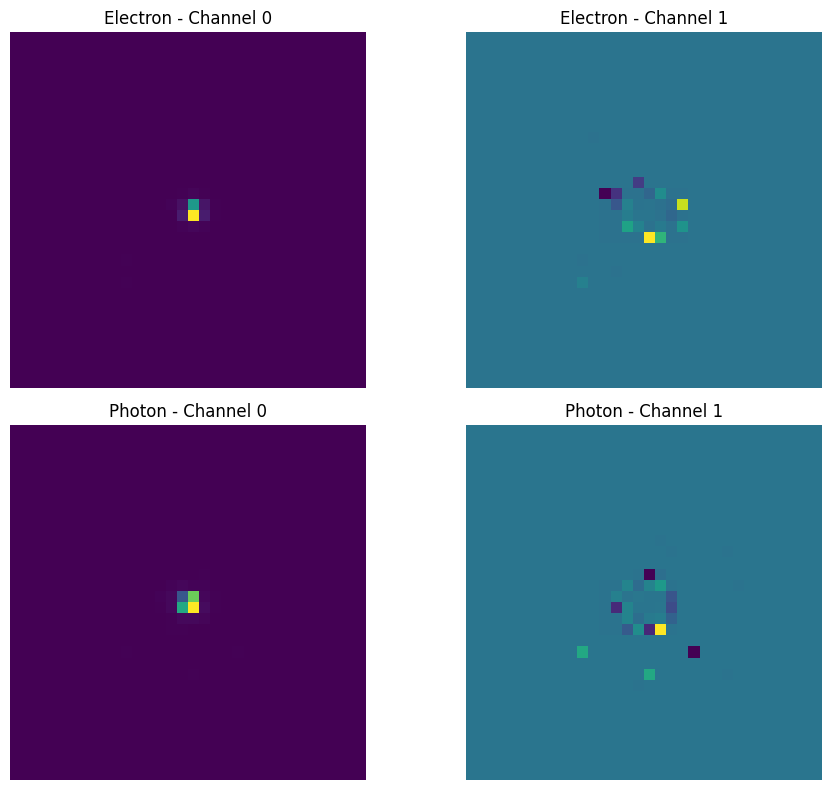

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
e_idx = np.random.randint(0, len(elec_data["X"]))

axes[0, 0].imshow(elec_data["X"][e_idx][..., 0])
axes[0, 0].set_title("Electron - Channel 0")
axes[0, 0].axis("off")
axes[0, 1].imshow(elec_data["X"][e_idx][..., 1])
axes[0, 1].set_title("Electron - Channel 1")
axes[0, 1].axis("off")

p_idx = np.random.randint(0, len(phot_data["X"]))

axes[1, 0].imshow(phot_data["X"][p_idx][..., 0])
axes[1, 0].set_title("Photon - Channel 0")
axes[1, 0].axis("off")
axes[1, 1].imshow(phot_data["X"][p_idx][..., 1])
axes[1, 1].set_title("Photon - Channel 1")
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()

Let's set up some seeds and configs for the task

In [10]:
del elec_data, phot_data, x_elec, x_phot, y_elec, y_phot


In [11]:
# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Let's make a function to load the data 

In [12]:
def load_data():
    electron_file = h5py.File(
        "/kaggle/input/electron-photon-classification-dataset/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5",
        "r",
    )
    electron_X = electron_file["X"][:]
    electron_y = electron_file["y"][:]

    photon_file = h5py.File(
        "/kaggle/input/electron-photon-classification-dataset/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5",
        "r",
    )
    photon_X = photon_file["X"][:]
    photon_y = photon_file["y"][:]

    X = np.concatenate([electron_X, photon_X], axis=0)
    y = np.concatenate([electron_y, photon_y], axis=0)

    # Rearrange dimensions for PyTorch (B, C, H, W)
    X = np.transpose(X, (0, 3, 1, 2))

    print(f"Total X shape: {X.shape}")
    print(f"Total y shape: {y.shape}")

    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.LongTensor(y)

    return X_tensor, y_tensor

The architure is a ResNet-15 with Squeeze-and-Excitation (SE) blocks, with dropout regularization

In [13]:
class SE_Block(nn.Module):
    """Squeeze-and-Excitation Block"""

    def __init__(self, channels, reduction_ratio=16):
        super(SE_Block, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        bs, c, _, _ = x.shape
        y = self.squeeze(x).view(bs, c)
        y = self.excitation(y).view(bs, c, 1, 1)
        return x * y.expand_as(x)


In [14]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, dropout_rate=0.2):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout2d(dropout_rate)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout2d(dropout_rate)
        self.se = SE_Block(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.dropout1(out)
        out = self.bn2(self.conv2(out))
        out = self.dropout2(out)
        out = self.se(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out


In [15]:
class ResNet15(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2, dropout_rate=0.3):
        super(ResNet15, self).__init__()
        self.in_channels = 64
        self.dropout_rate = dropout_rate

        self.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(256 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.dropout(out)
        out = self.fc(out)

        return out

Now for the main training loop

Loading data...
Total X shape: (498000, 2, 32, 32)
Total y shape: (498000,)
Train dataset size: 398400
Test dataset size: 99600
Creating model...


Training epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Training batches:   0%|          | 0/779 [00:00<?, ?it/s]

Evaluation batches:   0%|          | 0/195 [00:00<?, ?it/s]


New best model saved with accuracy: 66.51%


Training batches:   0%|          | 0/779 [00:00<?, ?it/s]

Evaluation batches:   0%|          | 0/195 [00:00<?, ?it/s]


New best model saved with accuracy: 70.14%


Training batches:   0%|          | 0/779 [00:00<?, ?it/s]

Evaluation batches:   0%|          | 0/195 [00:00<?, ?it/s]


New best model saved with accuracy: 71.44%


Training batches:   0%|          | 0/779 [00:00<?, ?it/s]

Evaluation batches:   0%|          | 0/195 [00:00<?, ?it/s]


New best model saved with accuracy: 71.61%


Training batches:   0%|          | 0/779 [00:00<?, ?it/s]

Evaluation batches:   0%|          | 0/195 [00:00<?, ?it/s]


New best model saved with accuracy: 71.85%


Training batches:   0%|          | 0/779 [00:00<?, ?it/s]

Evaluation batches:   0%|          | 0/195 [00:00<?, ?it/s]

Early stopping triggered: 1/5


Training batches:   0%|          | 0/779 [00:00<?, ?it/s]

Evaluation batches:   0%|          | 0/195 [00:00<?, ?it/s]


New best model saved with accuracy: 72.21%


Training batches:   0%|          | 0/779 [00:00<?, ?it/s]

Evaluation batches:   0%|          | 0/195 [00:00<?, ?it/s]


New best model saved with accuracy: 72.42%


Training batches:   0%|          | 0/779 [00:00<?, ?it/s]

Evaluation batches:   0%|          | 0/195 [00:00<?, ?it/s]


New best model saved with accuracy: 72.75%


Training batches:   0%|          | 0/779 [00:00<?, ?it/s]

Evaluation batches:   0%|          | 0/195 [00:00<?, ?it/s]


New best model saved with accuracy: 72.81%


Training batches:   0%|          | 0/779 [00:00<?, ?it/s]

Evaluation batches:   0%|          | 0/195 [00:00<?, ?it/s]

Early stopping triggered: 1/5


Training batches:   0%|          | 0/779 [00:00<?, ?it/s]

Evaluation batches:   0%|          | 0/195 [00:00<?, ?it/s]


New best model saved with accuracy: 72.97%


Training batches:   0%|          | 0/779 [00:00<?, ?it/s]

Evaluation batches:   0%|          | 0/195 [00:00<?, ?it/s]


New best model saved with accuracy: 73.26%


Training batches:   0%|          | 0/779 [00:00<?, ?it/s]

Evaluation batches:   0%|          | 0/195 [00:00<?, ?it/s]


New best model saved with accuracy: 73.45%


Training batches:   0%|          | 0/779 [00:00<?, ?it/s]

Evaluation batches:   0%|          | 0/195 [00:00<?, ?it/s]

Early stopping triggered: 1/5


Training batches:   0%|          | 0/779 [00:00<?, ?it/s]

Evaluation batches:   0%|          | 0/195 [00:00<?, ?it/s]

Early stopping triggered: 2/5


Training batches:   0%|          | 0/779 [00:00<?, ?it/s]

Evaluation batches:   0%|          | 0/195 [00:00<?, ?it/s]

Early stopping triggered: 3/5


Training batches:   0%|          | 0/779 [00:00<?, ?it/s]

Evaluation batches:   0%|          | 0/195 [00:00<?, ?it/s]

Early stopping triggered: 4/5


Training batches:   0%|          | 0/779 [00:00<?, ?it/s]

Evaluation batches:   0%|          | 0/195 [00:00<?, ?it/s]


New best model saved with accuracy: 73.50%


Training batches:   0%|          | 0/779 [00:00<?, ?it/s]

Evaluation batches:   0%|          | 0/195 [00:00<?, ?it/s]

Early stopping triggered: 1/5


Training batches:   0%|          | 0/779 [00:00<?, ?it/s]

Evaluation batches:   0%|          | 0/195 [00:00<?, ?it/s]

Early stopping triggered: 2/5


Training batches:   0%|          | 0/779 [00:00<?, ?it/s]

Evaluation batches:   0%|          | 0/195 [00:00<?, ?it/s]

Early stopping triggered: 3/5


Training batches:   0%|          | 0/779 [00:00<?, ?it/s]

Evaluation batches:   0%|          | 0/195 [00:00<?, ?it/s]


New best model saved with accuracy: 73.53%


Training batches:   0%|          | 0/779 [00:00<?, ?it/s]

Evaluation batches:   0%|          | 0/195 [00:00<?, ?it/s]

Early stopping triggered: 1/5


Training batches:   0%|          | 0/779 [00:00<?, ?it/s]

Evaluation batches:   0%|          | 0/195 [00:00<?, ?it/s]

Early stopping triggered: 2/5


Training batches:   0%|          | 0/779 [00:00<?, ?it/s]

Evaluation batches:   0%|          | 0/195 [00:00<?, ?it/s]

Early stopping triggered: 3/5


Training batches:   0%|          | 0/779 [00:00<?, ?it/s]

Evaluation batches:   0%|          | 0/195 [00:00<?, ?it/s]

Early stopping triggered: 4/5


Training batches:   0%|          | 0/779 [00:00<?, ?it/s]

Evaluation batches:   0%|          | 0/195 [00:00<?, ?it/s]

Early stopping triggered: 5/5

Early stopping triggered after 28 epochs

Training completed!


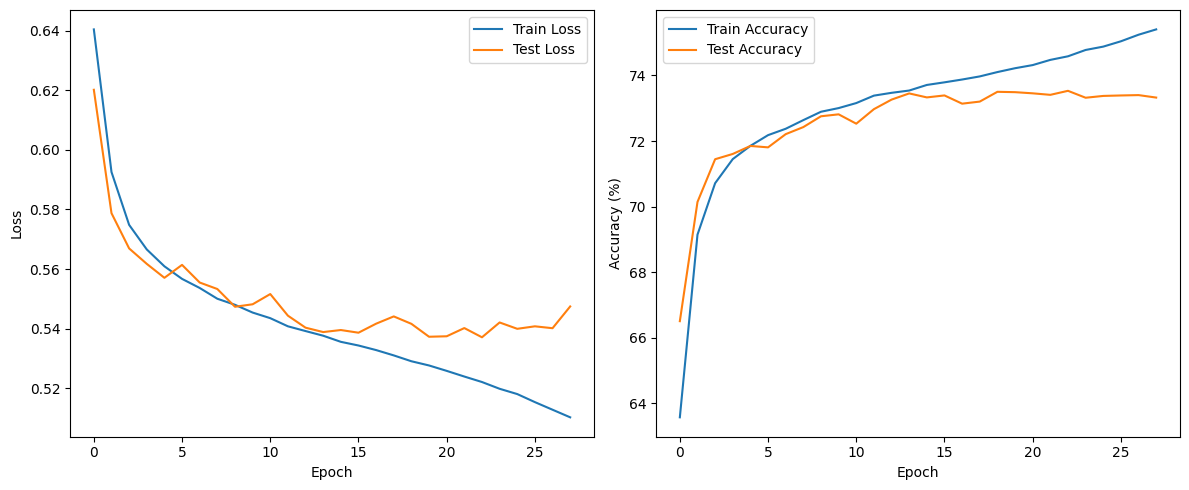

Performing final evaluation...


<ipython-input-16-5d93608406e6>:165: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_resnet15_model.pth"))


Evaluation batches:   0%|          | 0/195 [00:00<?, ?it/s]

Final Test Accuracy: 73.53%

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.71      0.73     50007
           1       0.72      0.76      0.74     49593

    accuracy                           0.74     99600
   macro avg       0.74      0.74      0.74     99600
weighted avg       0.74      0.74      0.74     99600



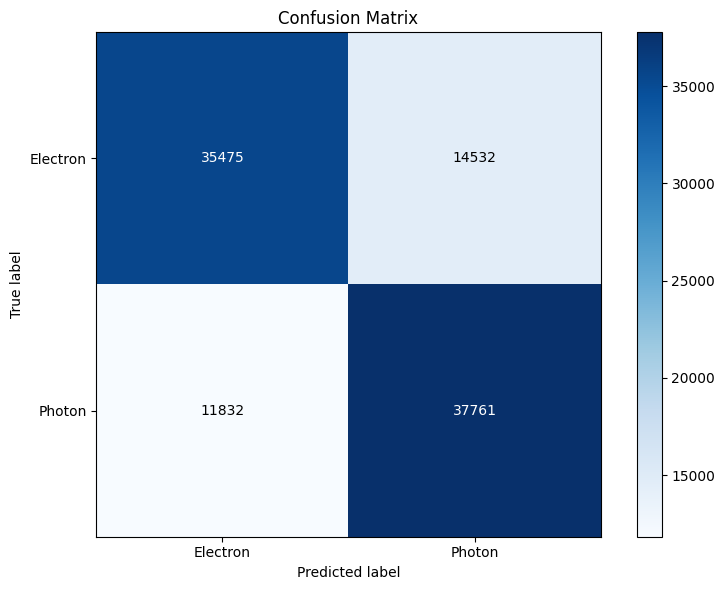

In [16]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_pbar = tqdm(train_loader, desc="Training batches", leave=False)

    for inputs, targets in train_pbar:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        train_pbar.set_postfix({"loss": loss.item(), "acc": 100.0 * correct / total})

    train_loss = running_loss / len(train_loader)
    train_acc = 100.0 * correct / total

    return train_loss, train_acc


def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    eval_pbar = tqdm(test_loader, desc="Evaluation batches", leave=False)

    with torch.no_grad():
        for inputs, targets in eval_pbar:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)

            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

            eval_pbar.set_postfix({"loss": loss.item(), "acc": 100.0 * correct / total})

    test_loss = running_loss / len(test_loader)
    test_acc = 100.0 * correct / total

    return test_loss, test_acc, all_preds, all_targets


def main():
    print("Loading data...")
    X, y = load_data()

    dataset = TensorDataset(X, y)

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")

    batch_size = 512
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    print("Creating model...")
    model = ResNet15(BasicBlock, [2, 2, 2], dropout_rate=0.3).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "min", patience=5, factor=0.5
    )

    # Training
    num_epochs = 30
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    patience = 5
    counter = 0
    best_acc = 0.0

    epoch_pbar = tqdm(range(num_epochs), desc="Training epochs")

    for epoch in epoch_pbar:
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc, _, _ = evaluate(model, test_loader, criterion, device)

        scheduler.step(test_loss)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        epoch_pbar.set_postfix(
            {
                "train_loss": f"{train_loss:.4f}",
                "train_acc": f"{train_acc:.2f}%",
                "test_loss": f"{test_loss:.4f}",
                "test_acc": f"{test_acc:.2f}%",
                "lr": f"{optimizer.param_groups[0]['lr']:.6f}",
            }
        )

        # Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            counter = 0
            torch.save(model.state_dict(), "best_resnet15_model.pth")
            print(f"\nNew best model saved with accuracy: {best_acc:.2f}%")
        else:
            counter += 1
            print(f"Early stopping triggered: {counter}/{patience}")

        if counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

    print("\nTraining completed!")

    # Plot training progress
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Accuracy")
    plt.plot(test_accs, label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.tight_layout()
    plt.savefig("training_progress.png")
    plt.show()

    # Final evaluation
    print("Performing final evaluation...")
    model.load_state_dict(torch.load("best_resnet15_model.pth"))
    _, test_acc, all_preds, all_targets = evaluate(
        model, test_loader, criterion, device
    )

    print(f"Final Test Accuracy: {test_acc:.2f}%")
    print("\nClassification Report:")
    print(classification_report(all_targets, all_preds))

    # Confusion Matrix
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()

    classes = ["Electron", "Photon"]
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j,
                i,
                format(cm[i, j], "d"),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    plt.show()


if __name__ == "__main__":
    main()
